In [1]:
from PIL import Image, ImageDraw
import numpy as np
import os, random

os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)

for i in range(1000):
    img = Image.new("RGB", (64, 64), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    x, y = random.randint(10, 54), random.randint(10, 54)
    size = 10
    draw.rectangle([x-size, y-size, x+size, y+size], fill=(255, 0, 0))
    img.save(f"images/{i}.png")
    with open(f"labels/{i}.txt", "w") as f:
        f.write(f"{x},{y}")


In [3]:
!ls

C3_W1_Lab_1_transfer_learning_cats_dogs.ipynb  images
C3_W1_Lab_2_Transfer_Learning_CIFAR_10.ipynb   labels
C3_W1_Lab_3_Object_Localization.ipynb	       Untitled.ipynb


In [ ]:
# second dataset so the classifier 

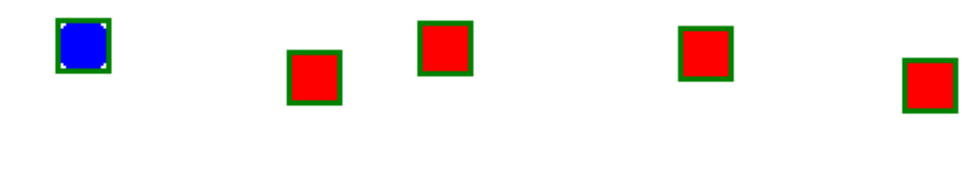

In [68]:
import random
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os

# Directories
img_dir = "shape_dataset/images"
ann_dir = "shape_dataset/annotations"
os.makedirs(img_dir, exist_ok=True)
os.makedirs(ann_dir, exist_ok=True)

# Image and shape parameters
img_size = 64
shape_size = 10
num_images = 50  # Number of images to generate

# Function to create bounding box XML
def create_voc_xml(filename, width, height, bbox, shape_name, folder="images"):
    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "folder").text = folder
    ET.SubElement(annotation, "filename").text = filename
    ET.SubElement(annotation, "path").text = os.path.join(folder, filename)

    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = "3"

    ET.SubElement(annotation, "segmented").text = "0"

    obj = ET.SubElement(annotation, "object")
    ET.SubElement(obj, "name").text = shape_name
    ET.SubElement(obj, "pose").text = "Unspecified"
    ET.SubElement(obj, "truncated").text = "0"
    ET.SubElement(obj, "difficult").text = "0"

    bndbox = ET.SubElement(obj, "bndbox")
    ET.SubElement(bndbox, "xmin").text = str(bbox[0])
    ET.SubElement(bndbox, "ymin").text = str(bbox[1])
    ET.SubElement(bndbox, "xmax").text = str(bbox[2])
    ET.SubElement(bndbox, "ymax").text = str(bbox[3])

    return ET.ElementTree(annotation)

# Function to draw shapes (circle or square) and return the bounding box
def draw_shape(img_size, shape_type="square"):
    shape_size = 10
    img = Image.new("RGB", (img_size, img_size), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    x, y = random.randint(shape_size, img_size - shape_size), random.randint(shape_size, img_size - shape_size)
    xmin, ymin = x - shape_size, y - shape_size
    xmax, ymax = x + shape_size, y + shape_size

    if shape_type == "square":
        draw.rectangle([xmin, ymin, xmax, ymax], fill=(255, 0, 0))
    elif shape_type == "circle":
        draw.ellipse([xmin, ymin, xmax, ymax], fill=(0, 0, 255))

    return img, (xmin, ymin, xmax, ymax), shape_type

# Generate images and annotations
for i in range(num_images):
    shape_type = random.choice(["square", "circle"])
    img, bbox, shape_name = draw_shape(img_size, shape_type)
    img_filename = f"{i:04d}.png"
    img.save(os.path.join(img_dir, img_filename))

    xml_filename = f"{i:04d}.xml"
    tree = create_voc_xml(img_filename, img_size, img_size, bbox, shape_name)
    tree.write(os.path.join(ann_dir, xml_filename))

# Function to draw bounding box on an image for display
def draw_bbox(image_path, xml_path):
    img = Image.open(image_path).convert("RGB")
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bndbox = root.find(".//bndbox")
    box = [int(bndbox.find(tag).text) for tag in ["xmin", "ymin", "xmax", "ymax"]]
    
    draw = ImageDraw.Draw(img)
    draw.rectangle(box, outline="green", width=2)
    return img

# Display a few images with bounding boxes
plt.figure(figsize=(10, 2))
for i, fname in enumerate(sorted(os.listdir(img_dir))[:5]):
    img_path = os.path.join(img_dir, fname)
    xml_path = os.path.join(ann_dir, fname.replace(".png", ".xml"))
    img_with_bbox = draw_bbox(img_path, xml_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img_with_bbox)
    plt.axis("off")
plt.tight_layout()
plt.show()


### Preparing the datasets

In [69]:
import tensorflow as tf
import xml.etree.ElementTree as ET
import os
import random

IMG_DIR = "shape_dataset/images"
ANN_DIR = "shape_dataset/annotations"

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    label = root.find(".//name").text
    label = 0 if label == "square" else 1  # square=0, circle=1

    bbox = root.find(".//bndbox")
    xmin = int(bbox.find("xmin").text)
    ymin = int(bbox.find("ymin").text)
    xmax = int(bbox.find("xmax").text)
    ymax = int(bbox.find("ymax").text)

    # Normalize bbox coordinates to [0, 1]
    bbox_norm = [xmin / 64, ymin / 64, xmax / 64, ymax / 64]
    return label, bbox_norm

# Build dataset entries
samples = []
for fname in sorted(os.listdir(IMG_DIR)):
    if fname.endswith(".png"):
        img_path = os.path.join(IMG_DIR, fname)
        xml_path = os.path.join(ANN_DIR, fname.replace(".png", ".xml"))
        label, bbox = parse_xml(xml_path)
        samples.append((img_path, label, bbox))

random.shuffle(samples)
split_idx = int(0.8 * len(samples))
train_samples = samples[:split_idx]
val_samples = samples[split_idx:]


In [72]:
def load_example(img_path, label, bbox):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # scale [0,1]
    return img, {"label": label, "bbox": bbox}

def make_dataset(samples, batch_size=4):
    img_paths, labels, bboxes = zip(*samples)
    ds = tf.data.Dataset.from_tensor_slices((list(img_paths), list(labels), list(bboxes)))
    ds = ds.map(lambda x, y, z: load_example(x, y, z))
    ds = ds.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_samples, batch_size=1)
val_ds = make_dataset(val_samples, batch_size=1)


train_ds and val_ds are tf.data.Dataset objects.

Each item is a tuple:
(image, {"label": shape_class, "bbox": normalized_box})

In [73]:
for images, targets in train_ds.take(1):
    print("Images:", images.shape)
    print("Labels:", targets["label"])
    print("BBoxes:", targets["bbox"])


Images: (1, 64, 64, 3)
Labels: tf.Tensor([1], shape=(1,), dtype=int32)
BBoxes: tf.Tensor([[0.40625  0.015625 0.71875  0.328125]], shape=(1, 4), dtype=float32)


In [25]:
import tensorflow as tf

2025-05-07 17:20:51.123856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 17:20:51.123894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 17:20:51.125168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 17:20:51.132014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 17:20:53.032983: W tensorflow/compiler/tf2

In [74]:
import tensorflow as tf

# Feature extractor
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu')(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    return x

# Dense layers
def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return x

# Classification branch (2 classes)
def classifier(inputs):
    return tf.keras.layers.Dense(2, activation='softmax', name='classification')(inputs)

# Bounding box regression branch (4 values)
def bounding_box_regression(inputs):
    return tf.keras.layers.Dense(4, name='bounding_box')(inputs)

# Complete model
def final_model(inputs):
    features = feature_extractor(inputs)
    dense = dense_layers(features)
    class_out = classifier(dense)
    bbox_out = bounding_box_regression(dense)
    return tf.keras.Model(inputs=inputs, outputs=[class_out, bbox_out])

# Compile model
def define_and_compile_model(input_shape=(64, 64, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    model = final_model(inputs)
    model.compile(
        optimizer='adam',
        loss={
            'classification': 'sparse_categorical_crossentropy',
            'bounding_box': 'mse'
        },
        metrics={
            'classification': 'accuracy',
            'bounding_box': 'mse'
        }
    )
    return model

# Instantiate and summarize
model = define_and_compile_model()
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 62, 62, 16)           448       ['input_7[0][0]']             
                                                                                                  
 average_pooling2d_18 (Aver  (None, 31, 31, 16)           0         ['conv2d_18[0][0]']           
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_19 (Conv2D)          (None, 29, 29, 32)           4640      ['average_pooling2d_18[0

Each item muste be:

(image_tensor, {"classification": int_label, "bounding_box": [xmin, ymin, xmax, ymax]})



not:

(image_tensor, {"label": ..., "bbox": ...})

In [76]:
def remap_keys(img, targets):
    return img, {
        "classification": targets["label"],
        "bounding_box": targets["bbox"]
    }

train_ds = train_ds.map(remap_keys)
val_ds = val_ds.map(remap_keys)


In [77]:
model = define_and_compile_model()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
40/40 [==============================] - 1s 11ms/step - loss: 0.7499 - classification_loss: 0.6780 - bounding_box_loss: 0.0719 - classification_accuracy: 0.6750 - bounding_box_mse: 0.0719 - val_loss: 0.5273 - val_classification_loss: 0.4287 - val_bounding_box_loss: 0.0985 - val_classification_accuracy: 0.8000 - val_bounding_box_mse: 0.0985
Epoch 2/10
40/40 [==============================] - 0s 7ms/step - loss: 0.2762 - classification_loss: 0.2134 - bounding_box_loss: 0.0628 - classification_accuracy: 0.9500 - bounding_box_mse: 0.0628 - val_loss: 0.1515 - val_classification_loss: 0.0797 - val_bounding_box_loss: 0.0718 - val_classification_accuracy: 1.0000 - val_bounding_box_mse: 0.0718
Epoch 3/10
40/40 [==============================] - 0s 7ms/step - loss: 0.1463 - classification_loss: 0.0488 - bounding_box_loss: 0.0975 - classification_accuracy: 1.0000 - bounding_box_mse: 0.0975 - val_loss: 0.1062 - val_classification_loss: 0.0561 - val_bounding_box_loss: 0.0501 - val_classi

In [39]:
model = define_and_compile_model()

In [40]:
EPOCHS = 5 # 45
#steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
#validation_steps = 1

training_dataset = train_ds
validation_dataset = val_ds


history = model.fit(training_dataset,
                    validation_data=validation_dataset, epochs=EPOCHS)

loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/5
10/10 [==============================] - 1s 30ms/step - loss: 0.8083 - classification_loss: 0.7296 - bounding_box_loss: 0.0787 - classification_accuracy: 0.6000 - bounding_box_mse: 0.0787 - val_loss: 0.7675 - val_classification_loss: 0.6720 - val_bounding_box_loss: 0.0955 - val_classification_accuracy: 0.5000 - val_bounding_box_mse: 0.0955
Epoch 2/5
10/10 [==============================] - 0s 15ms/step - loss: 0.6884 - classification_loss: 0.6281 - bounding_box_loss: 0.0603 - classification_accuracy: 0.6000 - bounding_box_mse: 0.0603 - val_loss: 0.7113 - val_classification_loss: 0.6368 - val_bounding_box_loss: 0.0745 - val_classification_accuracy: 0.5000 - val_bounding_box_mse: 0.0745
Epoch 3/5
10/10 [==============================] - 0s 15ms/step - loss: 0.5475 - classification_loss: 0.4940 - bounding_box_loss: 0.0536 - classification_accuracy: 0.6500 - bounding_box_mse: 0.0536 - val_loss: 0.4866 - val_classification_loss: 0.4173 - val_bounding_box_loss: 0.0693 - val_classif

In [41]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

In [78]:
image_batch, label_batch = next(iter(val_ds))

label_batch['bounding_box']

label_batch

{'classification': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'bounding_box': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.484375, 0.578125, 0.796875, 0.890625]], dtype=float32)>}

In [79]:
image

<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)>

1/1 [==============================] - 0s 16ms/step
[1] [[0.05348994 0.54890233 0.44089186 0.84774405]]
label {'classification': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, 'bounding_box': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.125   , 0.515625, 0.4375  , 0.828125]], dtype=float32)>}
[0.05348994 0.54890233 0.44089186 0.84774405]


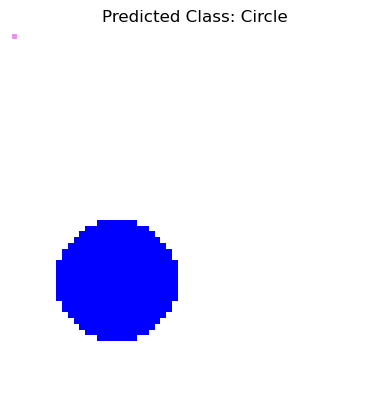

In [81]:
# Get one batch from the val_ds
image_batch, label_batch = next(iter(val_ds))

# Get the first image from the batch (assuming the batch size is > 1)
image = image_batch[0]
label = label_batch #[0]

# Make a prediction using the model
predictions = model.predict(tf.expand_dims(image, axis=0))  # Add batch dimension

# Assuming the predictions are in two parts (classification and bounding box)
predicted_class = np.argmax(predictions[0], axis=1)  # Classification prediction
predicted_bbox = predictions[1]  # Bounding box prediction


print(predicted_class, predicted_bbox)

print('label',label)


# Display the image with the predicted bounding box
def plot_image_with_bbox(image, predicted_class, predicted_bbox):
    plt.imshow(image)
    xmin, ymin, xmax, ymax = predicted_bbox[0]
    
    
    print(predicted_bbox[0])
    
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                      edgecolor='violet', facecolor='none', lw=2))
    plt.title(f"Predicted Class: {'Circle' if predicted_class == 1 else 'Square'}")
    plt.axis('off')
    plt.show()
    

# Plot the image and bounding box
plot_image_with_bbox(image, predicted_class, predicted_bbox)

1/1 [==============================] - 0s 17ms/step
Predicted class: [1]
Predicted bbox: [[0.46252578 0.5886995  0.85547346 0.90397805]]
Label: {'classification': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, 'bounding_box': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.484375, 0.578125, 0.796875, 0.890625]], dtype=float32)>}
Scaled Bounding Box: [29.60165023803711, 37.6767692565918, 54.750301361083984, 57.85459518432617]


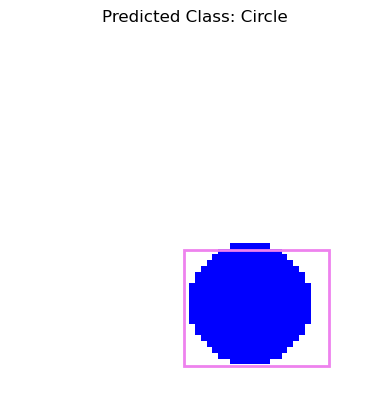

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch from the val_ds
image_batch, label_batch = next(iter(val_ds))

# Get the first image from the batch (assuming the batch size is > 1)
image = image_batch[0]
label = label_batch #[0]

# Make a prediction using the model
predictions = model.predict(tf.expand_dims(image, axis=0))  # Add batch dimension

# Assuming the predictions are in two parts (classification and bounding box)
predicted_class = np.argmax(predictions[0], axis=1)  # Classification prediction
predicted_bbox = predictions[1]  # Bounding box prediction

print("Predicted class:", predicted_class)
print("Predicted bbox:", predicted_bbox)

print("Label:", label)

# Display the image with the predicted bounding box
def plot_image_with_bbox(image, predicted_class, predicted_bbox):
    plt.imshow(image)
    
    # Assuming the bounding box is in normalized coordinates (0-1), scale to image size
    xmin, ymin, xmax, ymax = predicted_bbox[0]  # Get the first bounding box
    
    # Scale the coordinates to the image size (64x64)
    xmin, ymin, xmax, ymax = xmin * 64, ymin * 64, xmax * 64, ymax * 64
    
    print("Scaled Bounding Box:", [xmin, ymin, xmax, ymax])
    
    # Plot the bounding box on the image
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                      edgecolor='violet', facecolor='none', lw=2))
    plt.title(f"Predicted Class: {'Circle' if predicted_class == 1 else 'Square'}")
    plt.axis('off')
    plt.show()
    

# Plot the image and bounding box
plot_image_with_bbox(image, predicted_class, predicted_bbox)


In [87]:
label['bounding_box']

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.484375, 0.578125, 0.796875, 0.890625]], dtype=float32)>

In [93]:
label['bounding_box'][0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.484375, 0.578125, 0.796875, 0.890625], dtype=float32)>

In [88]:
predicted_bbox[0]

array([0.46252578, 0.5886995 , 0.85547346, 0.90397805], dtype=float32)

In [97]:
def intersection_over_union(pred_box, true_box):
    #xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    #xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = pred_box
    xmin_true, ymin_true, xmax_true, ymax_true = true_box
    

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

In [99]:
intersection_over_union(predicted_bbox[0], label['bounding_box'][0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.7418025>

In [ ]:
#https://www.kodeco.com/books/machine-learning-by-tutorials/v2.0/chapters/9-beyond-classification